
Top 10 movies similar to The Matrix:
1. The Matrix Revolutions (0.972)
2. The Matrix Reloaded (0.972)
3. Terminator 3: Rise of the Machines (0.443)
4. I, Robot (0.365)
5. Blade Runner (0.357)
6. Interstellar (0.307)
7. The Terminator (0.278)
8. Terminator Salvation (0.269)
9. Terminator Genisys (0.244)
10. Metropolis (0.243)

Top 10 movies similar to Inception:
1. Don Jon (0.341)
2. Looper (0.280)
3. Highlander: Endgame (0.247)
4. Hesher (0.241)
5. The Count of Monte Cristo (0.239)
6. The Helix... Loaded (0.221)
7. Catch Me If You Can (0.220)
8. The Juror (0.217)
9. 50/50 (0.206)
10. (500) Days of Summer (0.204)

Top 10 movies similar to The Dark Knight:
1. The Dark Knight Rises (0.617)
2. Batman Begins (0.491)
3. The Prestige (0.374)
4. Kick-Ass (0.330)
5. Kick-Ass 2 (0.320)
6. Amidst the Devil's Wings (0.276)
7. Batman & Robin (0.249)
8. Watchmen (0.238)
9. Batman (0.218)
10. The Imaginarium of Doctor Parnassus (0.218)


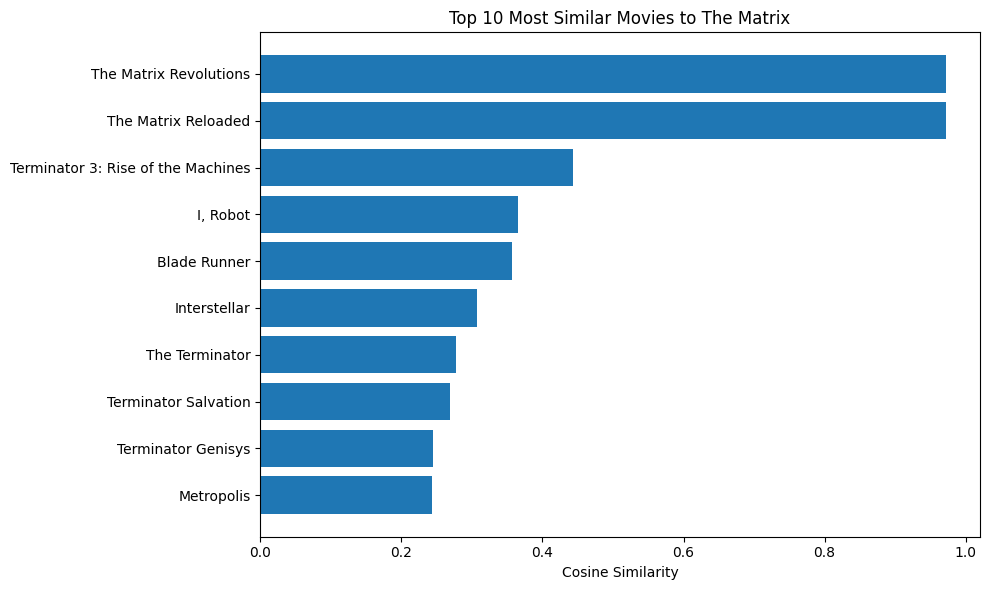

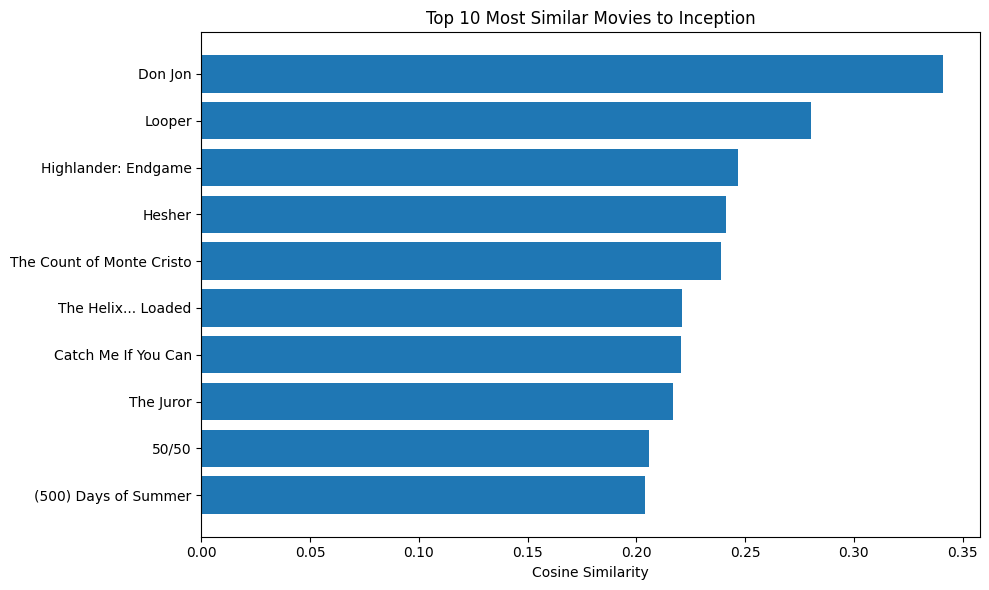

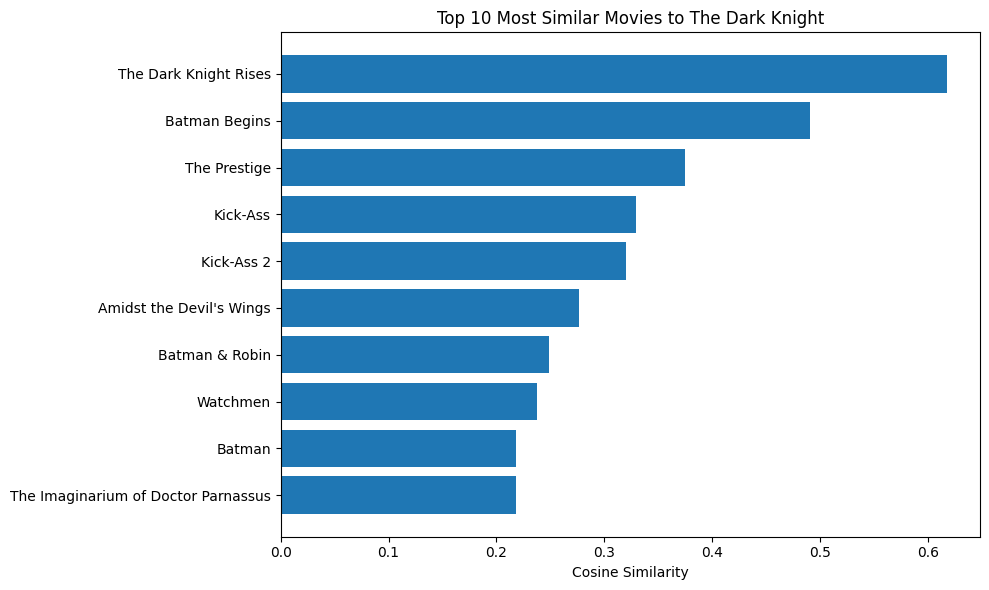

In [3]:
import pandas as pd
import numpy as np
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load datasets
movies_df = pd.read_csv("tmdb_5000_movies.csv")
credits_df = pd.read_csv("tmdb_5000_credits.csv")

# Merge datasets on movie ID
merged_df = movies_df.merge(credits_df, left_on='id', right_on='movie_id')

# Select and rename relevant columns
merged_df = merged_df[['title_x', 'genres', 'keywords', 'cast', 'crew']]
merged_df.rename(columns={'title_x': 'title'}, inplace=True)

# Function to extract director from crew
def get_director(crew_data):
    try:
        for person in ast.literal_eval(crew_data):
            if person['job'] == 'Director':
                return person['name']
    except:
        return np.nan

# Function to extract top N names from JSON-like fields
def get_top_items(data, key, n=3):
    try:
        return [item[key] for item in ast.literal_eval(data)[:n]]
    except:
        return []

# Apply cleaning functions
merged_df['director'] = merged_df['crew'].apply(get_director)
merged_df['cast'] = merged_df['cast'].apply(lambda x: get_top_items(x, 'name', 3))
merged_df['keywords'] = merged_df['keywords'].apply(lambda x: get_top_items(x, 'name', 3))
merged_df['genres'] = merged_df['genres'].apply(lambda x: get_top_items(x, 'name', 3))
merged_df['director'] = merged_df['director'].fillna('')

# Combine selected features into one metadata string
merged_df['metadata'] = merged_df.apply(lambda x: ' '.join(x['cast']) + ' ' +
                                                  x['director'] + ' ' +
                                                  ' '.join(x['keywords']) + ' ' +
                                                  ' '.join(x['genres']), axis=1)

# Vectorize metadata using TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(merged_df['metadata'])

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to get top N similar movies
def get_similar_movies(title, df, sim_matrix, top_n=10):
    idx = df[df['title'] == title].index[0]
    sim_scores = list(enumerate(sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    similar_movies = [(df.iloc[i[0]].title, i[1]) for i in sim_scores]
    return similar_movies

# Query titles
queries = ["The Matrix", "Inception", "The Dark Knight"]
similar_movies_results = {query: get_similar_movies(query, merged_df, cosine_sim) for query in queries}

# Print results
for query in queries:
    print(f"\nTop 10 movies similar to {query}:")
    for i, (title, score) in enumerate(similar_movies_results[query]):
        print(f"{i+1}. {title} ({score:.3f})")

# Example plot for The Matrix
matrix_titles = [i[0] for i in similar_movies_results["The Matrix"]]
matrix_scores = [i[1] for i in similar_movies_results["The Matrix"]]

plt.figure(figsize=(10, 6))
plt.barh(matrix_titles[::-1], matrix_scores[::-1])
plt.xlabel("Cosine Similarity")
plt.title("Top 10 Most Similar Movies to The Matrix")
plt.tight_layout()
plt.show()

# Plot for Inception
inception_titles = [i[0] for i in similar_movies_results["Inception"]]
inception_scores = [i[1] for i in similar_movies_results["Inception"]]

plt.figure(figsize=(10, 6))
plt.barh(inception_titles[::-1], inception_scores[::-1])
plt.xlabel("Cosine Similarity")
plt.title("Top 10 Most Similar Movies to Inception")
plt.tight_layout()
plt.show()

# Plot for The Dark Knight
tdk_titles = [i[0] for i in similar_movies_results["The Dark Knight"]]
tdk_scores = [i[1] for i in similar_movies_results["The Dark Knight"]]

plt.figure(figsize=(10, 6))
plt.barh(tdk_titles[::-1], tdk_scores[::-1])
plt.xlabel("Cosine Similarity")
plt.title("Top 10 Most Similar Movies to The Dark Knight")
plt.tight_layout()
plt.show()
